<a href="https://colab.research.google.com/github/sugiyama404/forecast_sp500/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
import time

In [ ]:
class TimeSeriesConverter:
    """
    時系列データを変換するためのクラス
    """
    def __init__(self, row_name: str, observation_period: int, predict_period: int):
        """
        コンストラクタ

        Args:
            row_name: 列名 (str)
            observation_period: 観測期間 (int)
            predict_period: 予測期間 (int)
        """
        self.row_name = row_name
        self.observation_period = observation_period
        self.predict_period = predict_period

    def get_dataset(self, df: pd.DataFrame) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        対象となるデータを加工して、入力データと出力データを作る。
        Args:
            df: 対象となるデータ (pandas DataFrame)
        Returns:
            x_data: 入力データ (tf.Tensor)
            y_data: 出力データ (tf.Tensor)
        """
        x_data, y_data = self._get_data(df)

        x_data = tf.convert_to_tensor(x_data, dtype=tf.float32)
        y_data = tf.convert_to_tensor(y_data, dtype=tf.float32)
        return x_data, y_data

    def _get_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        データの取得を行う
        Args:
            df: 対象となるデータ (pandas DataFrame)
        Returns:
            x_data: 入力データ (np.ndarray)
            y_data: 出力データ (np.ndarray)
        """
        x_data = []
        y_data = []
        for i in range(len(df) - self.observation_period - self.predict_period):
            x_data.append(df[self.row_name].iloc[i: i + self.observation_period])
            # y_data.append(df[self.row_name].iloc[i+self.predict_period: i + self.observation_period+self.predict_period])
            y_data.append(df[self.row_name][i + self.observation_period + self.predict_period])
        return np.array(x_data), np.array(y_data)

In [ ]:
class DataPreprocessor:
    def __init__(self, date_col_name: str, data_col_name: str):
        """
        このクラスは、さらなる分析のために時系列データを前処理します。
        Args:
            date_col_name (str)：日付データを含むカラムの名前。
            data_col_name (str)：前処理されるデータを含むカラムの名前。
        """
        self.date_col_name = date_col_name
        self.data_col_name = data_col_name

    def preprocess(self, data_path: str)->pd.DataFrame:
        """
        指定された CSV ファイルのパスからデータを前処理します。
        Args:
            data_path (str)：時系列データを含むCSVファイルへのパス。
        Returns:
            pandas.DataFrame：pandas.DataFrame: 前処理されたデータ。
        """
        df = pd.read_csv(data_path)
        df[self.date_col_name] = pd.to_datetime(df[self.date_col_name], format='%Y-%m-%d')
        df.dropna(subset=[self.date_col_name, self.data_col_name], inplace=True)
        scaler = StandardScaler()
        df[self.data_col_name] = scaler.fit_transform(df[[self.data_col_name]])
        return df

In [ ]:
drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/reinforcement_learning/'
nov_train = '/content/drive/My Drive/' + nov_dir + 'sp500_train.csv'
nov_test = '/content/drive/My Drive/' + nov_dir + 'sp500_test.csv'

DATE_RNAME = 'Date'
DATA_RNAME = 'SP500'
OBSERVATION_PERIOD = 60
PREDICT_PERIOD = 1

c = TimeSeriesConverter(DATA_RNAME, OBSERVATION_PERIOD, PREDICT_PERIOD)
dp = DataPreprocessor(date_col_name=DATE_RNAME, data_col_name=DATA_RNAME)

df_train = dp.preprocess(nov_train)
train_x_data, train_y_data = c.get_dataset(df_train)

df_test = dp.preprocess(nov_test)
test_x_data, test_y_data = c.get_dataset(df_test)

Mounted at /content/drive/


# ストップウォッチ関数

In [ ]:
def stopwatch(end_time,start_time):
  elapsed_time = int(end_time - start_time)

  elapsed_hour = elapsed_time // 3600
  elapsed_minute = (elapsed_time % 3600) // 60
  elapsed_second = (elapsed_time % 3600 % 60)

  mozi = str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2)
  return mozi

# モデル構築

In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, head_size, num_heads, ff_dim, dropout, attention_axes, epsilon, kernel_size):
        super().__init__()

        self.layer_norm1 = layers.LayerNormalization(epsilon=epsilon)
        self.multi_head_attention = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout, attention_axes=attention_axes
        )
        self.dropout1 = layers.Dropout(dropout)
        self.layer_norm2 = layers.LayerNormalization(epsilon=epsilon)
        self.conv1d = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")
        self.dropout2 = layers.Dropout(dropout)
        self.conv1d_out = layers.Conv1D(filters=head_size * num_heads, kernel_size=kernel_size)

    def call(self, inputs):
        x = self.layer_norm1(inputs)
        x = self.multi_head_attention(x, x)
        x = self.dropout1(x)
        res = x + inputs

        x = self.layer_norm2(res)
        x = self.conv1d(x)
        x = self.dropout2(x)
        x = self.conv1d_out(x)
        return x + res

In [ ]:
"""
Transformerモデル
call関数:
    inputs:
    バッチサイズ: batch_size
    シーケンス長: seq_len
    特徴量数: num_features

    kernel_size: 畳み込み演算のカーネルサイズ (デフォルト: 1)

    outputs:
        n_outputs: 出力データの次元数 (デフォルト: 5)
        (None, 5)
"""
class TransformerModel(tf.keras.Model):
    def __init__(self,
                 head_size,
                 num_heads,
                 ff_dim,
                 num_trans_blocks,
                 mlp_units,
                 dropout=0,
                 mlp_dropout=0,
                 attention_axes=None,
                 epsilon=1e-6,
                 kernel_size=1,
                 n_outputs=PREDICT_PERIOD):
        super().__init__()

        self.encoder_blocks = [
            EncoderBlock(
                head_size=head_size,
                num_heads=num_heads,
                ff_dim=ff_dim,
                dropout=dropout,
                attention_axes=attention_axes,
                epsilon=epsilon,
                kernel_size=kernel_size
            ) for _ in range(num_trans_blocks)
        ]

        self.pooling = layers.GlobalAveragePooling1D(data_format="channels_first")
        self.mlp = tf.keras.Sequential([
            layers.Dense(dim, activation="relu") for dim in mlp_units
        ])
        self.dropout = layers.Dropout(mlp_dropout)
        self.output_layer = layers.Dense(n_outputs)

    def call(self, inputs):
        x = inputs
        for block in self.encoder_blocks:
            x = block(x)

        x = self.pooling(x)
        x = self.mlp(x)
        x = self.dropout(x)
        return self.output_layer(x)

# 学習

In [ ]:
model = TransformerModel(
    head_size=15,
    num_heads=4,
    ff_dim=2,
    num_trans_blocks=4,
    mlp_units=[256],
    mlp_dropout=0.10,
    dropout=0.10,
    attention_axes=1
)

optimizer = Adam(learning_rate=0.001)
loss_fn = MeanSquaredError()

x_train = tf.reshape(train_x_data, (-1, 60, 1)) # (567, 60)
y_train = tf.reshape(train_y_data, (-1, 1)) # (567, 1)

print(x_train.shape) # (567, 60, 1)
print(y_train.shape) # (567, 1)

EPOCH_TIMES = 200
start_time = time.time()

model.compile(optimizer, loss_fn)
hist = model.fit(x_train, y_train, epochs=EPOCH_TIMES, verbose=0)
print("Leanring time: ", stopwatch(time.time(),start_time))

(567, 60, 1)
(567, 1)
Leanring time:  00:01:28


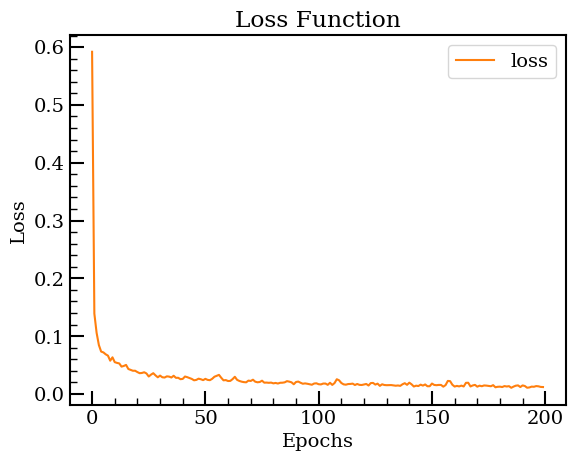

In [ ]:
nov_dir2 = 'Colab Notebooks/workspace/export/'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["xtick.major.width"] = 1.5
plt.rcParams["ytick.major.width"] = 1.5
plt.rcParams["xtick.minor.width"] = 1.0
plt.rcParams["ytick.minor.width"] = 1.0
plt.rcParams["xtick.major.size"] = 10
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.minor.size"] = 5
plt.rcParams["font.size"] = 14
plt.rcParams["axes.linewidth"] = 1.5

loss = hist.history['loss']
epochs = len(loss)

plt.plot(range(epochs), loss, label="loss", color='tab:orange')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
nov_path2 = '/content/drive/My Drive/' + nov_dir2 + 'transformer_lossfunc.png'

plt.savefig(nov_path2)
plt.show()
plt.close('all')

In [ ]:
x_test = tf.reshape(test_x_data, (-1, 60, 1))
y_test = tf.reshape(test_y_data, (-1, 1))
predict = model.predict(x_test)

26/26 [==============================] - 1s 8ms/step


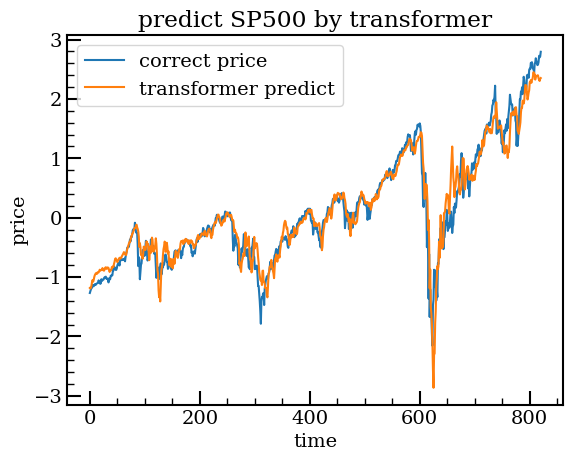

In [ ]:
# prompt: plot y_test,predict

import matplotlib.pyplot as plt
plt.plot(y_test, label="correct price", color='tab:blue')
plt.plot(predict, label="transformer predict", color='tab:orange')
plt.title('predict SP500 by transformer')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
nov_path = '/content/drive/My Drive/' + nov_dir2 + 'transformer_sp500.png'

plt.savefig(nov_path)
plt.show()
plt.close('all')
